# VAEを用いた数字合成

TensorFlowチュートリアルのコードを一部利用

## ライブラリのインストール

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.data import Dataset
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam

## モデルの設定

In [35]:
class CondVAE(Model):
    def __init__(self, n_zdim, bs):
        super(CondVAE, self).__init__()
        self.n_zdim = n_zdim
        self.bs = bs
        self.encoder = self.encoder_model(self.n_zdim)
        self.decoder = self.decoder_model(self.n_zdim) 

    # エンコーダモデルの定義
    def encoder_model(self, n_zdim):
        encoder_in = Input(shape=(28, 28, 11)) # 教師ラベルチャンネルを含む
        h = Conv2D(32, (3, 3), strides=(2, 2), activation='relu')(encoder_in)
        h = Conv2D(64, (3, 3), strides=(2, 2), activation='relu')(h)
        h = Flatten()(h)
        z_mu = Dense(n_zdim, name='z_mu')(h) # 平均
        z_logvar = Dense(n_zdim, name='z_logvar')(h) # 対数分散
        return Model(inputs=encoder_in, outputs=[z_mu, z_logvar]) # 潜在変数の平均・分散，数字分類結果

    # デコーダモデルの定義
    def decoder_model(self, n_zdim): # 潜在ベクトル次元+数字のone-hotベクトル(10次元) 
        latent_in = Input(shape=(n_zdim+10, )) # 教師ラベル（ワンホット連結済み）
        h = Dense(7*7*32, activation='relu')(latent_in)
        h = Reshape(target_shape=(7, 7, 32))(h)
        h = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(h)
        h = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(h)
        reconst = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='linear', name='output')(h)
        return Model(inputs=latent_in, outputs=reconst)
        
    # 再パラメタライゼーショントリック
    def reparameterization(self, z_mu, z_logvar):
        epsilon = tf.random.normal(shape=tf.shape(z_logvar), mean=0, stddev=1.0) # epsilon生成
        return z_mu + epsilon * tf.exp(0.5 * z_logvar)

    # エンコード処理
    def encode(self, x, y): 
        # 教師ラベルは(28, 28, 10)のテンソルに変換してオリジナル画像にチャンネルを合成する
        bs = x.shape[0] # バッチサイズを取得
        one = tf.ones((28, 28, 1)) # すべての要素が1の(28, 28, 1)のテンソルを作る
        onehot = tf.reshape(tf.one_hot(y, 10), [bs, 1, 1, 10]) # (1, 1)の画像形式のone-hotベクトルを用意する
        onehot = one * onehot # (28, 28, 10)の画像one-hotベクトル。該当する教師ラベルのチャンネルのみ1，それ以外のチャンネルは0になる。例えば，ラベルが3の場合，3チャンネル目はすべて1，それ以外のチャンネルは0となる                
        x = tf.concat([x, onehot], axis=3) # 入力画像xとone-hotベクトルを結合して(bs, 28, 28, 11)のデータにする
        mean, logvar = self.encoder(x)
        return mean, logvar

    # デコード処理
    def decode(self, z, y):
        # 教師ラベルは(10, )のワンホットベクトルして潜在ベクトルとcancatする
        z = tf.concat([z, tf.one_hot(y, 10)], axis=1) 
        return self.decoder(z)

    # 確率密度関数
    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

    # 損失計算・誤差逆伝播関数をオーバーライド    
    def train_step(self, data):        
        x, y = data
        with tf.GradientTape() as tape:
            z_mu, z_logvar = self.encode(x, y) # 入力画像の潜在ベクトルを計算
            z = self.reparameterization(z_mu, z_logvar) # 潜在ベクトルの生成
            x_logit = self.decode(z, y) # 潜在ベクトルから画像を生成
            """
            損失計算（TensorFlowチュートリアルのコードを利用）
            """
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
            logpz = self.log_normal_pdf(z, 0., 0.)
            logqz_x = self.log_normal_pdf(z, z_mu, z_logvar)
            total_loss = -tf.reduce_mean(logpx_z + logpz - logqz_x)

        gradients = tape.gradient(total_loss, self.trainable_variables) # 勾配計算
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables)) # 誤差逆伝播
        return {'loss': total_loss}

## テストデータの読み込み

テストデータの画像のみ利用

In [36]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # 訓練データの画像のみ利用
testset = np.expand_dims(np.float32(x_test), -1) / 255. # チャンネルを増やして，float32に変換して正規化

## モデルの作成

モデルの作成(入力:100次元，バッチサイズ:50)

最適化関数の設定(初期学習率:0.0001)

In [37]:
# モデルの作成(入力:100次元，バッチサイズ:50)
model = CondVAE(100, 50) 

# テスト

In [38]:
import random
import matplotlib.pyplot as plt

## モデルの読み込み

In [42]:
model_enc = os.path.join('model', 'MNIST_SUPVAE_ENC')
model_dec = os.path.join('model', 'MNIST_SUPVAE_DEC')
model.encoder.load_weights(model_enc)
model.decoder.load_weights(model_dec)

## 画像保存用関数の設定

In [43]:
def to_numpy(tftensorimg):
    npy = tftensorimg.numpy().reshape(28, 28) # NumPyへ変換
    return np.uint8(npy)


## AEを使った画像生成・合成と画像の表示・保存

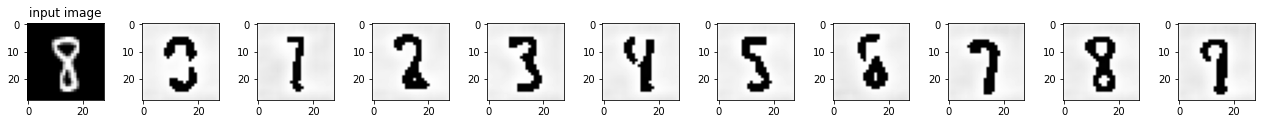

In [44]:
#VAEを使った画像生成・合成
idx = random.randint(0, 9999) # 任意の画像を1つ取り出す
x = np.expand_dims(testset[idx], 0) # バッチ化
z_mu, z_logvar = model.encode(x, y_test[idx]) # エンコーダに通す
z = model.reparameterization(z_mu, z_logvar) # 潜在ベクトルを求める    
outputs = [model.decode(z, np.array([i])) for i in range(10)]

#画像の表示・保存
fig = plt.figure(figsize=(22, 2), dpi=72)
plt.subplots_adjust(wspace=0.5) # 間隔調整
ax = fig.add_subplot(1, 11, 1)
ax.set_title('input image')
ax.imshow(x_test[idx], cmap='gray')
for i in range(10):
    img = to_numpy(outputs[i])
    ax = fig.add_subplot(1, 11, i+2) # 1行10列の画像
    ax.imshow(img, cmap='gray')        
plt.savefig('generated.png')
